In [1]:
import sys
sys.path.append("../utils/")

In [2]:
from backend_manager import BackendManager
from runner import Runner
from data_collector import DataCollector
from filter_on_kpis import FilterOnKPIs
from runner_competing import RunnerCompeting
from case_duration_manager import CaseDurationsManager
from rank_variants import RankVariants
from measurements_visualizer import MeasurementsVisualizer
from measure_and_rank import measure_and_rank

In [3]:
import os
import time
import shutil

#### 01. Backend -NA

In [4]:
#submit_cmd = "sbatch submit.sh"
#bm = BackendManager("login18-1.hpc.itc.rwth-aachen.de", "as641651", submit_cmd)
#bm = BackendManager("login18-1.hpc.itc.rwth-aachen.de", "as641651")
#bm.connect()
bm = None

#### 02. Runner

In [5]:
args = ["75","10"]

exp_dir = "../GLS/variants-linnea/"
if bm:
    exp_dir = "~/PhD/performance-analyazer/Experiment2/GLS/variants-linnea"
threads = 4
runner = Runner("MC", exp_dir, args, threads=threads, backend=bm)

#### 03. Job name - NA

In [6]:
if bm:
    args_dir_name = runner.args_dir.split('/')[-1]
    job_name = "{}_T{}".format(args_dir_name, threads)
    job_name

#### 04. DataCollector

In [7]:
if bm:
    exp_dir_local = "../GLS/variants-linnea/"
    local_data_dir = os.path.join(exp_dir_local, "cluster-experiments", "{}".format(args_dir_name))
    if os.path.exists(local_data_dir):
        shutil.rmtree(local_data_dir)
    os.makedirs(local_data_dir)
    dc = DataCollector(local_data_dir, runner.args_dir, bm)
else:
    dc = DataCollector(runner.args_dir)

#### 05. Look for already available data

In [8]:
case_table = dc.get_case_table()
case_table

,case:concept:name,case:flops,case:num_kernels
0,algorithm36,219000.0,8
1,algorithm67,223000.0,8
2,algorithm94,230000.0,8
3,algorithm53,221000.0,10
4,algorithm12,214000.0,8
...,...,...,...
95,algorithm70,223000.0,8
96,algorithm21,215000.0,8
97,algorithm83,227000.0,8
98,algorithm15,214000.0,8


In [9]:
cm = CaseDurationsManager()
cm.collect_case_durations(dc)

Collected data from 37 runs


In [11]:
#cm.case_durations.head()

#### 05. Generate Experiments

In [12]:
ret = runner.generate_experiments()
ret

New solution:..............2.7e+05
New solution:.............2.12e+05
Nodes:.........................385
Nodes:.........................717
Nodes:.........................986
Nodes:........................1280
Nodes:........................1624
Nodes:........................1912
Nodes:........................2156
Nodes:........................2379
Nodes:........................2635
Nodes:........................2837
Nodes:........................3031
Nodes:........................3304
Nodes:........................3581
Nodes:........................3905
Nodes:........................4283
Nodes:........................4659
Nodes:........................4943
Nodes:........................5272
Nodes:........................5569
Nodes:........................5820
Nodes:........................6138
Nodes:........................6380
Nodes:........................6605
Nodes:........................6808
Nodes:........................7096
Nodes:........................7288
Nodes:..............

0

#### 06. Single-run Experiment

In [13]:
ret = runner.run_experiments()
ret

Running Experiments locally
Experiments completed locally


0

In [14]:
if bm:
    while bm.check_slrum_status(job_name) != 0:
        print("Waiting for Job to complete.")
        time.sleep(5)

In [21]:
case_table = dc.get_case_table()
measurements = dc.get_all_runtimes_table()

In [22]:
case_table

,case:concept:name,case:flops,case:num_kernels
0,algorithm36,219000.0,8
1,algorithm67,223000.0,8
2,algorithm94,230000.0,8
3,algorithm53,221000.0,10
4,algorithm12,214000.0,8
...,...,...,...
95,algorithm70,223000.0,8
96,algorithm21,215000.0,8
97,algorithm83,227000.0,8
98,algorithm15,214000.0,8


In [23]:
measurements.head()

,case:concept:name,concept:name,concept:flops,concept:operation,concept:kernel,timestamp:start,timestamp:end
0,algorithm36,LAPACK.potrf_1.41e+05,141000.0,(L2 L2^T) = M,"LAPACK.potrf!('L', ml1)",1.656089e+09,1.656089e+09
1,algorithm36,trsv_5.62e+03,5620.0,tmp68 = (L2^-1 y),"trsv!('L', 'N', 'N', ml1, ml2)",1.656089e+09,1.656089e+09
2,algorithm36,trsm_5.62e+04,56200.0,tmp12 = (L2^-1 X),"trsm!('L', 'L', 'N', 'N', 1.0, ml1, ml0)",1.656089e+09,1.656089e+09
3,algorithm36,syrk_7.5e+03,7500.0,tmp14 = (tmp12^T tmp12),"syrk!('L', 'T', 1.0, ml0, 0.0, ml3)",1.656089e+09,1.656089e+09
4,algorithm36,LAPACK.potrf_333,333.0,(L15 L15^T) = tmp14,"LAPACK.potrf!('L', ml3)",1.656089e+09,1.656089e+09


#### 07. KPI filter

In [24]:
kpi_filter = FilterOnKPIs(case_table, measurements)
kpi_filter.case_table

,case:concept:name,case:timestamp:start,case:timestamp:end,case:duration,case:flops,case:num_kernels,case:rel-flops,case:rel-duration
0,algorithm36,1.656089e+09,1.656089e+09,0.005044,219000.0,8,0.033019,128.000000
1,algorithm67,1.656089e+09,1.656089e+09,0.005023,223000.0,8,0.051887,127.463415
2,algorithm94,1.656089e+09,1.656089e+09,0.000116,230000.0,8,0.084906,1.969512
3,algorithm53,1.656089e+09,1.656089e+09,0.000103,221000.0,10,0.042453,1.634146
4,algorithm12,1.656089e+09,1.656089e+09,0.002321,214000.0,8,0.009434,58.359756
...,...,...,...,...,...,...,...,...
95,algorithm70,1.656089e+09,1.656089e+09,0.000067,223000.0,8,0.051887,0.713415
96,algorithm21,1.656089e+09,1.656089e+09,0.000061,215000.0,8,0.014151,0.560976
97,algorithm83,1.656089e+09,1.656089e+09,0.000049,227000.0,8,0.070755,0.256098
98,algorithm15,1.656089e+09,1.656089e+09,0.000055,214000.0,8,0.009434,0.402439


In [25]:
competing_cases = kpi_filter.filter_on_flops_and_rel_duration(0.5)
competing_cases

,case:concept:name,case:timestamp:start,case:timestamp:end,case:duration,case:flops,case:num_kernels,case:rel-flops,case:rel-duration
11,algorithm32,1.656089e+09,1.656089e+09,0.000051,218000.0,10,0.028302,0.304878
13,algorithm80,1.656089e+09,1.656089e+09,0.000052,227000.0,8,0.070755,0.329268
15,algorithm73,1.656089e+09,1.656089e+09,0.000047,225000.0,10,0.061321,0.201220
17,algorithm16,1.656089e+09,1.656089e+09,0.000058,214000.0,8,0.009434,0.481707
19,algorithm62,1.656089e+09,1.656089e+09,0.000057,222000.0,8,0.047170,0.457317
20,algorithm33,1.656089e+09,1.656089e+09,0.000044,218000.0,10,0.028302,0.121951
22,algorithm81,1.656089e+09,1.656089e+09,0.000050,227000.0,8,0.070755,0.280488
26,algorithm17,1.656089e+09,1.656089e+09,0.000055,214000.0,8,0.009434,0.402439
27,algorithm37,1.656089e+09,1.656089e+09,0.000043,219000.0,8,0.033019,0.103659
32,algorithm42,1.656089e+09,1.656089e+09,0.000039,220000.0,8,0.037736,0.000000


In [26]:
alg_seq_h0 = kpi_filter.get_alg_seq_sorted_on_duration(competing_cases)
alg_seq_h0

['algorithm42',
 'algorithm44',
 'algorithm41',
 'algorithm8',
 'algorithm40',
 'algorithm86',
 'algorithm30',
 'algorithm87',
 'algorithm71',
 'algorithm35',
 'algorithm5',
 'algorithm37',
 'algorithm33',
 'algorithm34',
 'algorithm82',
 'algorithm73',
 'algorithm1',
 'algorithm27',
 'algorithm83',
 'algorithm81',
 'algorithm85',
 'algorithm75',
 'algorithm32',
 'algorithm39',
 'algorithm76',
 'algorithm80',
 'algorithm61',
 'algorithm59',
 'algorithm79',
 'algorithm4',
 'algorithm28',
 'algorithm11',
 'algorithm17',
 'algorithm15',
 'algorithm74',
 'algorithm2',
 'algorithm3',
 'algorithm0',
 'algorithm62',
 'algorithm10',
 'algorithm16',
 'algorithm6',
 'algorithm64',
 'algorithm9',
 'algorithm7']

#### 08. Runner Competing and compute ranks

In [26]:
runner_competing = RunnerCompeting(alg_seq_h0, runner.args_dir,
                                          threads=threads, backend=bm)

In [27]:
# Clear previous measurements if available before re-running
dc.delete_competing_measurements()
dc.delete_ranks()

rep_steps = 3
eps=0.001
ret = runner_competing.compute_ranks(rep_steps=rep_steps, eps=eps)
ret

Running experiments locally.
Experiments completed locally
   case:concept:name  case:mean-rank
0        algorithm42        0.000000
1        algorithm44        0.000000
2        algorithm41        0.000000
3         algorithm8        0.000000
4        algorithm40        0.000000
5        algorithm86        0.000000
7        algorithm87        1.000000
9        algorithm35        1.000000
6        algorithm30        1.000000
8        algorithm71        1.142857
17       algorithm39        1.285714
10        algorithm5        1.285714
12       algorithm33        1.285714
13       algorithm34        1.285714
14       algorithm82        1.285714
16        algorithm1        1.285714
18        algorithm4        1.285714
20       algorithm81        1.428571
19       algorithm27        1.428571
11       algorithm37        1.428571
15       algorithm73        1.428571
21       algorithm75        1.714286
31        algorithm2        1.714286
22       algorithm83        2.285714
23       algorit

   case:concept:name  case:mean-rank
0        algorithm42        0.000000
1        algorithm27        0.000000
2         algorithm5        0.000000
3         algorithm7        0.000000
4        algorithm39        0.000000
28       algorithm44        0.142857
27        algorithm0        0.142857
26       algorithm40        0.142857
24       algorithm81        0.142857
23       algorithm30        0.142857
21       algorithm79        0.142857
20       algorithm28        0.142857
19       algorithm35        0.142857
18       algorithm82        0.142857
17        algorithm3        0.142857
16       algorithm33        0.142857
22       algorithm73        0.142857
14       algorithm86        0.142857
13        algorithm8        0.142857
12       algorithm34        0.142857
11        algorithm1        0.142857
10       algorithm32        0.142857
15       algorithm87        0.142857
9         algorithm6        0.142857
8        algorithm76        0.142857
7        algorithm80        0.142857
6

   case:concept:name  case:mean-rank
0        algorithm42        0.000000
1        algorithm86        0.000000
2        algorithm35        0.000000
3         algorithm2        0.000000
5        algorithm39        0.000000
25       algorithm81        0.142857
24       algorithm73        0.142857
23        algorithm7        0.142857
21        algorithm4        0.142857
20       algorithm74        0.142857
19       algorithm82        0.142857
18       algorithm34        0.142857
17       algorithm44        0.142857
16       algorithm28        0.142857
15       algorithm79        0.142857
22       algorithm40        0.142857
13        algorithm1        0.142857
14       algorithm30        0.142857
4        algorithm87        0.142857
7        algorithm37        0.142857
8        algorithm33        0.142857
6         algorithm8        0.142857
10        algorithm5        0.142857
11       algorithm41        0.142857
12        algorithm0        0.142857
9         algorithm3        0.142857
4

   case:concept:name  case:mean-rank
0        algorithm42        0.000000
1        algorithm40        0.000000
19       algorithm79        0.142857
20        algorithm3        0.142857
21        algorithm7        0.142857
23       algorithm74        0.142857
24       algorithm73        0.142857
25       algorithm81        0.142857
26       algorithm37        0.142857
27        algorithm4        0.142857
28       algorithm86        0.142857
29       algorithm82        0.142857
31        algorithm5        0.142857
32        algorithm2        0.142857
33       algorithm87        0.142857
18       algorithm27        0.142857
17       algorithm32        0.142857
22       algorithm39        0.142857
15        algorithm6        0.142857
2        algorithm75        0.142857
3        algorithm17        0.142857
16        algorithm1        0.142857
5        algorithm80        0.142857
6        algorithm28        0.142857
7        algorithm44        0.142857
8        algorithm34        0.142857
4

0

In [29]:
if bm:
    while bm.check_slrum_status(job_name) != 0:
        print("Waiting for Job to complete.")
        time.sleep(5)

#### 09. View Ranks

In [13]:
ranks = dc.get_ranks()
ranks

,case:concept:name,case:rank:q95-q5,case:rank:q90-q10,case:rank:q85-q15,case:rank:q80-q20,case:rank:q75-q25,case:rank:q70-q30,case:rank:q65-q35
0,algorithm42,0,0,0,0,0,0,0
1,algorithm44,0,0,0,0,0,0,0
2,algorithm40,0,0,0,0,0,0,0
3,algorithm6,0,0,0,0,0,0,0
4,algorithm5,0,0,0,0,0,0,0
5,algorithm80,0,0,0,0,0,0,0
6,algorithm32,0,0,0,0,0,0,0
7,algorithm0,0,0,0,0,0,0,0
8,algorithm85,0,0,0,0,0,0,0
9,algorithm8,0,0,0,0,0,0,0


In [14]:
mean_ranks = dc.get_mean_ranks()
mean_ranks

,case:concept:name,case:mean-rank,case:mean-rank.1,case:mean-rank.2,case:mean-rank.3,case:mean-rank.4,case:mean-rank.5,case:mean-rank.6,case:mean-rank.7,case:mean-rank.8,...,case:mean-rank.28,case:mean-rank.29,case:mean-rank.30,case:mean-rank.31,case:mean-rank.32,case:mean-rank.33,case:mean-rank.34,case:mean-rank.35,case:mean-rank.36,case:mean-rank.37
0,algorithm42,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,algorithm44,1,0.000000,0.000000,0.000000,0.000000,0.714286,0.285714,0.285714,0.714286,...,0.0,0.000000,0.0,0.142857,0.428571,0.142857,0.000000,0.000000,0.000000,0.000000
2,algorithm41,2,0.000000,0.000000,0.000000,0.000000,0.714286,0.285714,0.285714,0.714286,...,0.0,0.000000,0.0,0.142857,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000
3,algorithm8,3,0.000000,0.000000,0.000000,0.000000,0.714286,0.285714,0.285714,0.428571,...,0.0,0.000000,0.0,0.142857,0.428571,0.142857,0.000000,0.000000,0.000000,0.000000
4,algorithm40,4,0.000000,0.000000,0.000000,0.000000,0.714286,0.285714,0.285714,0.714286,...,0.0,0.000000,0.0,0.142857,0.428571,0.142857,0.000000,0.000000,0.000000,0.000000
5,algorithm86,5,0.000000,0.000000,0.142857,0.000000,0.714286,0.285714,0.285714,0.428571,...,0.0,0.000000,0.0,0.000000,0.428571,0.714286,0.428571,0.000000,0.000000,0.000000
6,algorithm30,6,1.000000,0.571429,1.571429,0.428571,1.428571,0.857143,0.285714,0.428571,...,0.0,0.000000,0.0,0.142857,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000
7,algorithm87,7,1.000000,0.000000,0.142857,0.000000,0.714286,0.285714,0.285714,0.428571,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,algorithm71,8,1.142857,0.142857,1.285714,0.000000,0.000000,0.142857,0.285714,0.714286,...,0.0,0.000000,0.0,0.142857,0.428571,0.142857,0.000000,0.000000,0.000000,0.000000
9,algorithm35,9,1.000000,0.000000,0.714286,0.000000,0.714286,0.285714,0.285714,0.428571,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### 10. Get Measurements

In [18]:
num_runs = mean_ranks.shape[1]-2
num_measurements = num_runs*rep_steps
print("Number of measurements per alg: ", num_measurements)

NameError: name 'rep_steps' is not defined

In [10]:
cm.collect_case_durations(dc)

Collected data from 37 runs


In [11]:
alg_measurements = cm.get_alg_measurements()

#### 11. Visualize Measurements

In [17]:
#mv = MeasurementsVisualizer(alg_measurements, alg_seq_h0)
mv = MeasurementsVisualizer(alg_measurements, list(ranks['case:concept:name']))

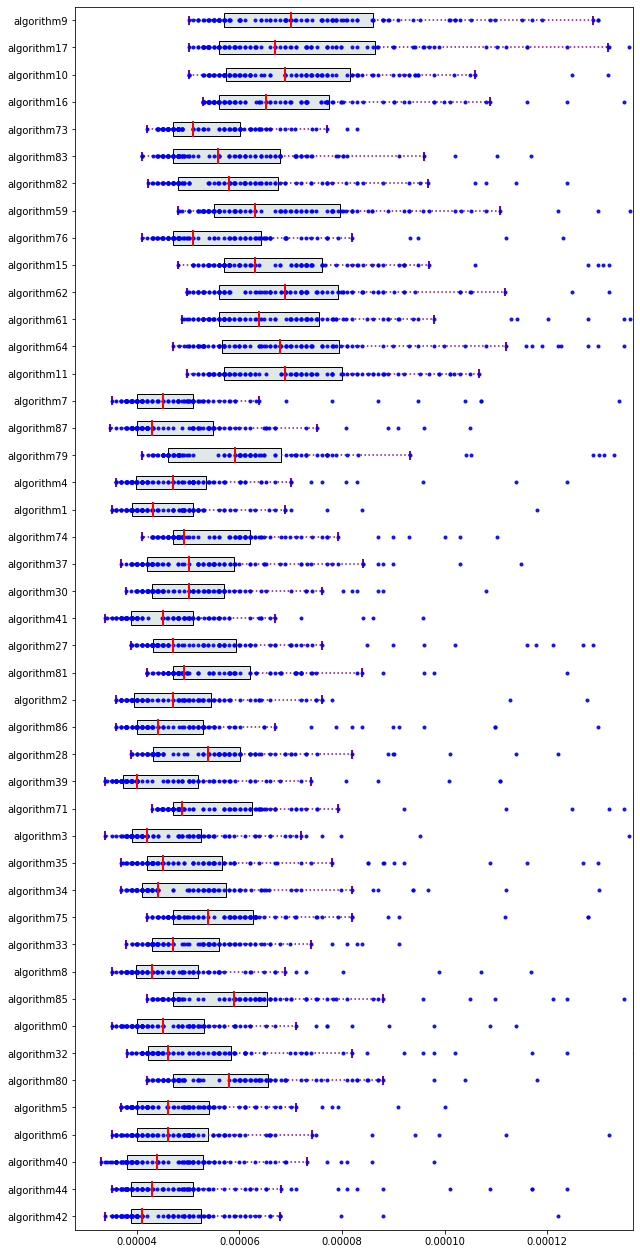

In [19]:
mv.show_measurements_boxplots(outliers=False, scale=0.5)

In [27]:
print("Initial Sequence: ", alg_seq_h0)
ranks.merge(mean_ranks.iloc[:,[0,-1]], on='case:concept:name')

Initial Sequence:  ['algorithm42', 'algorithm44', 'algorithm41', 'algorithm8', 'algorithm40', 'algorithm86', 'algorithm30', 'algorithm87', 'algorithm71', 'algorithm35', 'algorithm5', 'algorithm37', 'algorithm33', 'algorithm34', 'algorithm82', 'algorithm73', 'algorithm1', 'algorithm27', 'algorithm83', 'algorithm81', 'algorithm85', 'algorithm75', 'algorithm32', 'algorithm39', 'algorithm76', 'algorithm80', 'algorithm61', 'algorithm59', 'algorithm79', 'algorithm4', 'algorithm28', 'algorithm11', 'algorithm17', 'algorithm15', 'algorithm74', 'algorithm2', 'algorithm3', 'algorithm0', 'algorithm62', 'algorithm10', 'algorithm16', 'algorithm6', 'algorithm64', 'algorithm9', 'algorithm7']


,case:concept:name,case:rank:q95-q5,case:rank:q90-q10,case:rank:q85-q15,case:rank:q80-q20,case:rank:q75-q25,case:rank:q70-q30,case:rank:q65-q35,case:mean-rank.37
0,algorithm42,0,0,0,0,0,0,0,0.000000
1,algorithm44,0,0,0,0,0,0,0,0.000000
2,algorithm40,0,0,0,0,0,0,0,0.000000
3,algorithm6,0,0,0,0,0,0,0,0.000000
4,algorithm5,0,0,0,0,0,0,0,0.000000
5,algorithm80,0,0,0,0,0,0,0,0.000000
6,algorithm32,0,0,0,0,0,0,0,0.000000
7,algorithm0,0,0,0,0,0,0,0,0.000000
8,algorithm85,0,0,0,0,0,0,0,0.000000
9,algorithm8,0,0,0,0,0,0,0,0.000000


In [28]:
#competing_cases

In [31]:
#ranks.merge(mean_ranks.iloc[:,[0,-1]], on='case:concept:name')

In [32]:
ranks.iloc[:,[0,5]].merge(mean_ranks.iloc[:,[0,-1]], on='case:concept:name')\
.merge(competing_cases.iloc[:,[0,4,6,7]], on='case:concept:name')

,case:concept:name,case:rank:q75-q25,case:mean-rank.37,case:flops,case:rel-flops,case:rel-duration
0,algorithm42,0,0.000000,220000.0,0.037736,0.000000
1,algorithm44,0,0.000000,220000.0,0.037736,0.048780
2,algorithm40,0,0.000000,220000.0,0.037736,0.048780
3,algorithm6,0,0.000000,212000.0,0.000000,0.481707
4,algorithm5,0,0.000000,212000.0,0.000000,0.097561
5,algorithm80,0,0.000000,227000.0,0.070755,0.329268
6,algorithm32,0,0.000000,218000.0,0.028302,0.304878
7,algorithm0,0,0.000000,212000.0,0.000000,0.457317
8,algorithm85,0,0.000000,227000.0,0.070755,0.280488
9,algorithm8,0,0.000000,212000.0,0.000000,0.048780
